In [23]:
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import f1_score

import tensorflow as tf

from keras.applications import MobileNetV2

from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

from keras.models import Sequential

from keras.callbacks import EarlyStopping

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

from keras.optimizers import Adam

from keras.models import Model

import numpy as np

from keras.preprocessing import image

from keras.applications.mobilenet_v2 import preprocess_input

from keras.models import load_model

In [24]:
data = 'sports.csv'
df = pd.read_csv(data)

In [25]:
class_names = sorted(df['labels'].unique())
num_classes = len(class_names)
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}
df['label_index'] = df['labels'].map(class_to_index)

In [26]:
img_height, img_width = 256, 256
datagen = ImageDataGenerator(rescale=1./256)

In [27]:
# Train-Test-Validation Split
train_df = df[df['data set'] == 'train']
test_df = df[df['data set'] == 'test']
val_df = df[df['data set'] == 'valid']

# Create Data Generators
train_data_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='label_index',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='raw',
    shuffle=True
)

test_data_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='label_index',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

val_data_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='label_index',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

Found 13492 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


c:\Python\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [28]:
def f1_score_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    f1_per_class = []
    for class_id in range(100):
        class_true = tf.cast(tf.equal(y_true, class_id), tf.float32)
        class_pred = tf.cast(tf.equal(y_pred, class_id), tf.float32)
        f1 = tf.py_function(lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=1), (class_true, class_pred), tf.float32)
        f1_per_class.append(f1)
    return tf.reduce_mean(f1_per_class)

In [ ]:
mobilenet = MobileNetV2(
    input_shape=(256, 256, 3), include_top=False, weights="imagenet", classes=100
)
mobilenet.trainable = False

model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(100, activation="softmax"))

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", f1_score_metric]
)
model.summary()

callback = EarlyStopping(monitor="loss", patience=2)
history = model.fit(
    train_data_gen,
    epochs=5,
    batch_size=128,
    callbacks=[callback],
    validation_data=val_data_gen,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 100)               8192100   
                                                                 
Total params: 10450084 (39.86 MB)
Trainable params: 8192100 (31.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/5
211/211 [==============================] - 343s 2s/step - loss: 6.4651 - accuracy: 0.6708 - f1_score_metric: 0.7556 - val_loss: 1.7143 - val_accuracy: 0.8720 - val_f1_score_metric: 0.9257
Epoch 2/5
2

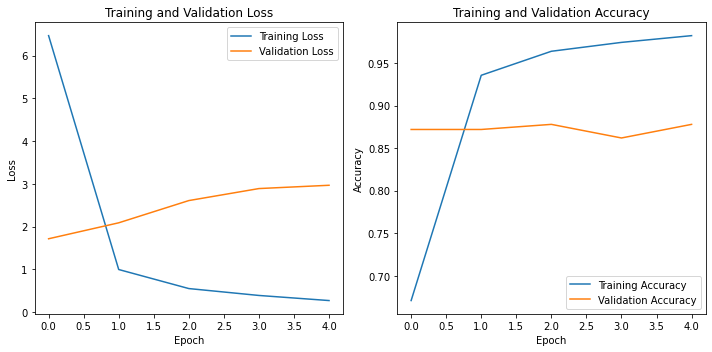

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
base_model = MobileNetV2(
    input_shape=(256, 256, 3), include_top=False, weights="imagenet"
)

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

from keras.models import Model

fine_tuned_model = Model(inputs=base_model.input, outputs=output)

fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_score_metric])

history_fine_tuned = fine_tuned_model.fit(
    train_data_gen,
    epochs=5,
    batch_size=32,
    validation_data=val_data_gen,
)

Epoch 1/5
211/211 [==============================] - 364s 2s/step - loss: 2.7046 - accuracy: 0.3546 - f1_score_metric: 0.5330 - val_loss: 0.8846 - val_accuracy: 0.8060 - val_f1_score_metric: 0.8964
Epoch 2/5
211/211 [==============================] - 363s 2s/step - loss: 1.1916 - accuracy: 0.6711 - f1_score_metric: 0.7366 - val_loss: 0.5327 - val_accuracy: 0.8780 - val_f1_score_metric: 0.9320
Epoch 3/5
211/211 [==============================] - 354s 2s/step - loss: 0.8757 - accuracy: 0.7476 - f1_score_metric: 0.7969 - val_loss: 0.4260 - val_accuracy: 0.9040 - val_f1_score_metric: 0.9440
Epoch 4/5
211/211 [==============================] - 347s 2s/step - loss: 0.7084 - accuracy: 0.7914 - f1_score_metric: 0.8286 - val_loss: 0.3403 - val_accuracy: 0.9020 - val_f1_score_metric: 0.9424
Epoch 5/5
211/211 [==============================] - 374s 2s/step - loss: 0.6141 - accuracy: 0.8194 - f1_score_metric: 0.8552 - val_loss: 0.3100 - val_accuracy: 0.9180 - val_f1_score_metric: 0.9509


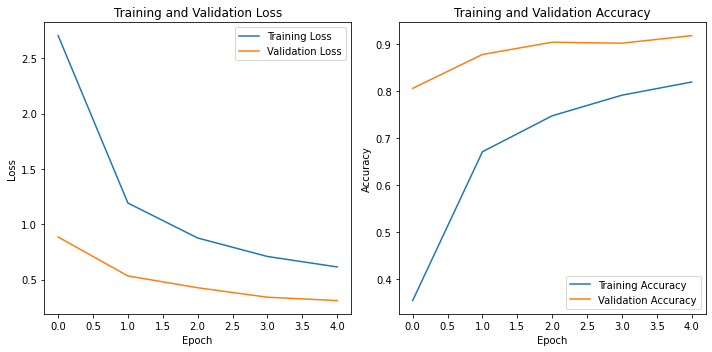

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine_tuned.history['loss'], label='Training Loss')
plt.plot(history_fine_tuned.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_fine_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Finding the index of the labels

prediction = model.predict(test_data_gen)
print(np.argmax(prediction, axis=-1))

8/8 [==============================] - 11s 1s/step
[ 0  0  0  0  0  1  1 22  1  1  2  2 63  2  2  3  3  3  3  3 83  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7 21 21  7  7  8  8  8  8  8  9 73  9
  9 50 10 10 10 10 10 11 11 11 11 11 12 77 12 12 21 13 13 13 13 13 14 14
 49 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 93
 19 19 19 93 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23
 24 24 24 24 24 25 28 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28
 28 29 29 81 29 29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33
 37 93 34 34 34 34 34 35 35 35 35 35 81 21 36 50 36 44 37 37 37 37 38 38
 38 38 38 39 39 39 39 90 40 40 40 40 40 41 41 41 41 41 42 42 21 42 42 43
 43 43 43 43 36 44 44 44 44 45 45 45 26 45 46 72 46 46 13 47 47 47 47 47
 38 48 48 48 48 49 49 49 49 49 50 50 50 50 50 51 51 51 51 51 52 25 52 52
 52 53 21 53 53 26 54 54 54 54 54 55 55 55 55 55 56 56 56 56 56 57 57 57
 80 57 58 58 58 58 58 59 59 59 59 59 60 60 60 60 60 61 61 61 61 61 62 62


In [ ]:
fine_tuned_model.save("mobileNetFINETUNED.h5")

c:\Python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 2s 626ms/step


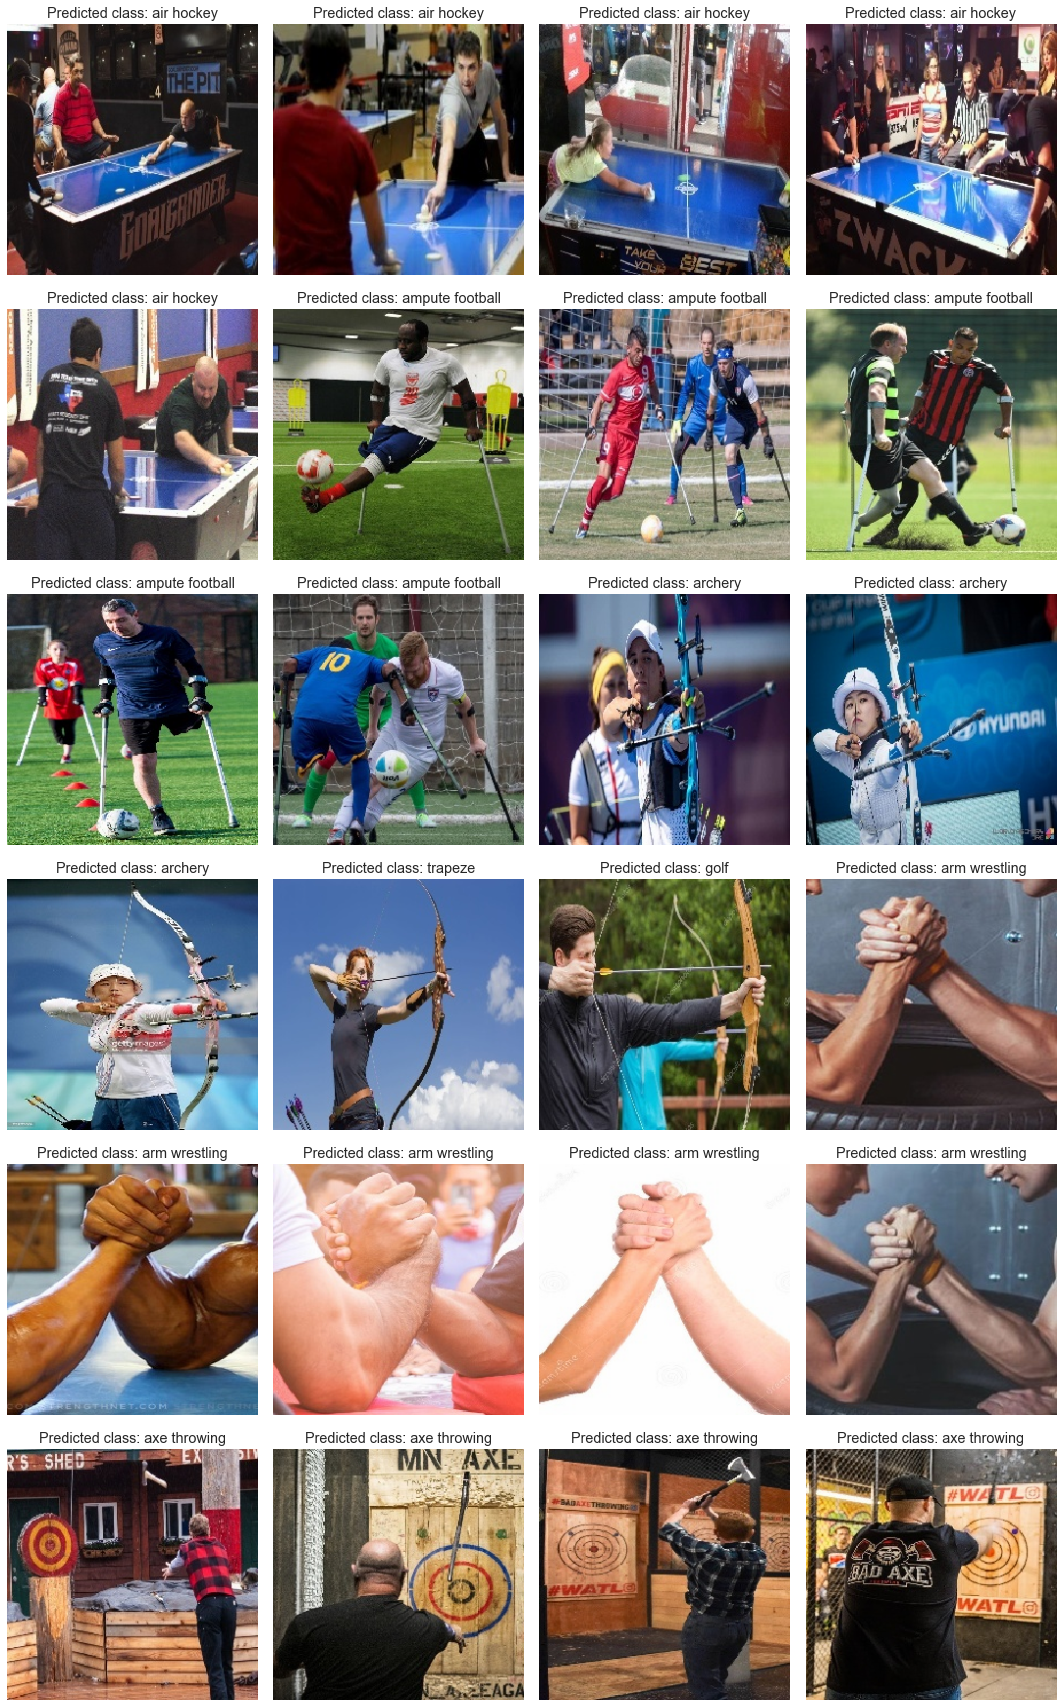

2/2 [==============================] - 1s 599ms/step


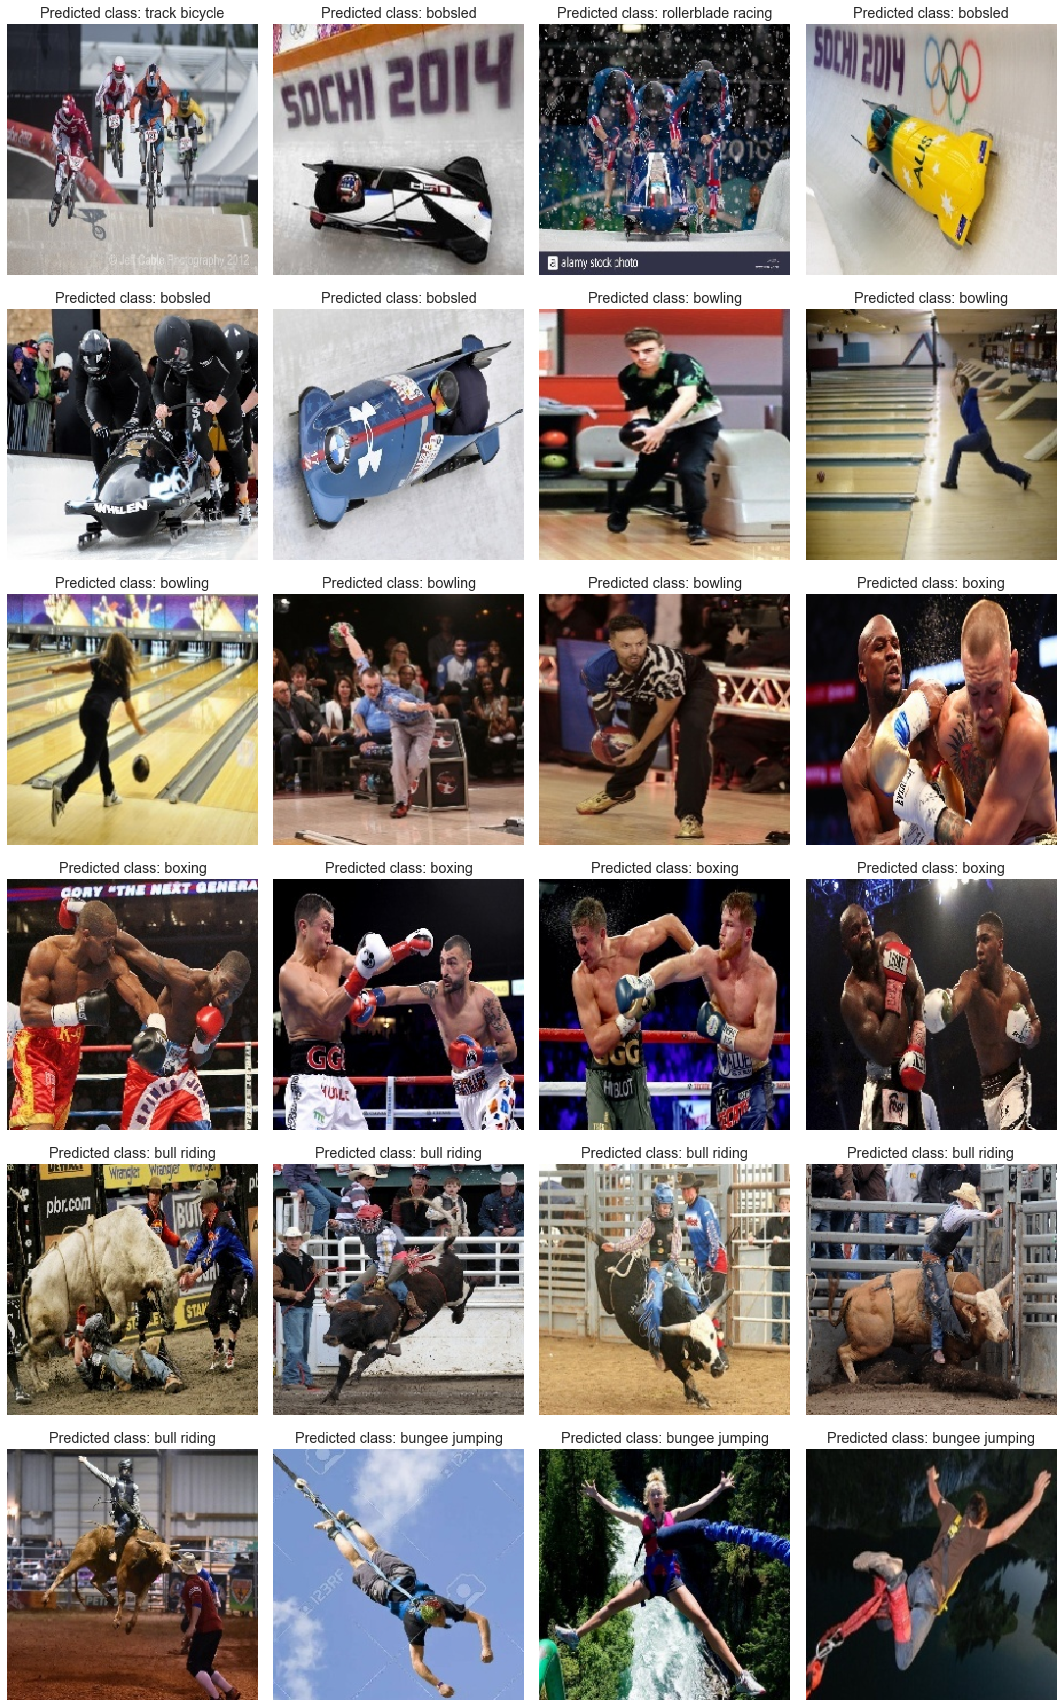

In [30]:
model = load_model("mobileNetFINETUNED.h5", custom_objects={'f1_score_metric': f1_score_metric})

batch_size = 24
num_batches = 2

# Create a subplot for displaying images
num_rows = batch_size // 4

for _ in range(num_batches):
    # Access the next batch from the validation data generator
    batch_images, batch_labels = next(val_data_gen)

    # Make predictions on the entire batch
    batch_predictions = model.predict(batch_images)

    # Get the index of the predicted class for each image in the batch
    predicted_class_indices = np.argmax(batch_predictions, axis=1)

    # Create a new figure for each batch
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))

    # Iterate through the batch and display images
    for i in range(batch_size):
        row_idx = i // 4
        col_idx = i % 4

        # Access the image from the batch
        selected_image = batch_images[i]

        # Resize the image to (256, 256)
        resized_image = image.smart_resize(selected_image, (256, 256))

        # Preprocess the resized image for model prediction
        preprocessed_image = preprocess_input(resized_image)

        # Get the corresponding class label from the class_names list
        predicted_class_label = class_names[predicted_class_indices[i]]

        # Display the selected image
        axs[row_idx, col_idx].imshow(selected_image)
        axs[row_idx, col_idx].set_title(f"Predicted class: {predicted_class_label}")
        axs[row_idx, col_idx].axis('off')

    # Remove any empty subplots
    for i in range(batch_size, num_rows * 4):
        row_idx = i // 4
        col_idx = i % 4
        axs[row_idx, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

8/8 [==============================] - 11s 1s/step
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       0.75      0.60      0.67         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       0.83      1.00      0.91         5
         balance beam       1.00      0.80      0.89         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      1.00      1.00         5
           basketball       0.80      0.80      0.80         5
       baton twirling       0.71      1.00      0.83         5
            bike polo       0.83      1.00      0.91         5
            billiards       1.00      1.00      1.00         5
                  bmx       0.80      0.80      0.80         5
              bobsled       0.80      0.80      0.80         5
   

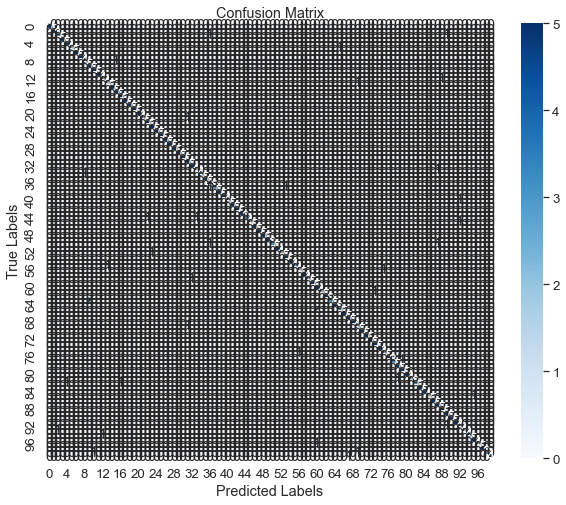

In [31]:
# Make predictions using your model
y_pred = model.predict(val_data_gen)

y_true = val_data_gen.labels

# Create a confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=-1))

# Create a heatmap for the confusion matrix without showing class labels
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display classification report
print(classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=class_names))

plt.show()
